# Assignment 1

In [1]:
import sys,os

MODEL_PATH = './bunny_v2'

if not os.path.exists(MODEL_PATH):
    print( 'cannot find \bunny_v2\, please update MODEL_PATH')
    exit(1)
else:
    print('found resources')

import time
import numpy as np
import trimesh
import transformations
from sklearn.neighbors import KDTree

import matplotlib
import matplotlib.pyplot as plt

found resources


**1. Align model M2 to model M1 using point-to-point ICP algorithm.**

In [2]:
# Compute rotation R and translation t to minimize

def fit_transform(ps1, ps2):
    """    
    Arguments:
    ps1: (N*d) numpy array of pointset from destination model
    ps2: (N*d) numpy array of pointset from source model
    
    Return:
    R: (d*d) rotation matrix
    t: (d*1) translation vector
    """
    
    # translate points to their centroids
    centroid_1 = np.mean(ps1, axis=0)
    centroid_2 = np.mean(ps2, axis=0)
    ps_1 = ps1 - centroid_1
    ps_2 = ps2 - centroid_2
    
    # compute rotation matrix
    A = np.dot(ps_2.T, ps_1)
    U, W, V_t = np.linalg.svd(A)
    R = np.dot(V_t.T, U.T)
    
    # special reflection case
    if np.linalg.det(R) < 0:
        V_t[-1,:] *= -1
        R = np.dot(V_t.T, U.T)
    
    # compute translation
    t = centroid_1.T - R @ np.dot(R, centroid_2.T)
    
    return R, t

In [3]:
# tranform M2 and return alignment error for each iteration

def transform_model(M1, M2, iterations=50):
    
    """    
    Arguments:
    M1: target model
    M2: source model to be transformed
    
    Return:
    M2_transformed: source model after transformation
    error: a list of alignment error for each iteration
    """
    
    M2_transformed = M2.copy()
    error = np.zeros(iterations)
    
    ps_1 = M1.vertices
    tree = KDTree(ps_1)

    for it in range(iterations):

        # 1. Sampling points on the surface of the mesh M2
        ps_2 = M2_transformed.sample(500)

        # 2. Match each point from ps_1 to closet point from ps_2
        distances, indices = tree.query(ps_2, 1)
        distances, indices = distances.ravel(), indices.ravel()
        error[it] = np.sum(distances) # compute alignment error

        # 3. Reject 10% bad pair
        sorted_d = distances.copy()
        sorted_d.sort()
        index = sorted_d.shape[0] // 10
        threshold = sorted_d[-index]

        pointset_1 = []
        pointset_2 = []
        for i, d in enumerate(distances):
            if d < threshold:
                pointset_1.append(np.array(ps_1[indices[i]]))
                pointset_2.append(np.array(ps_2[i]))

        pointset_1 = np.array(pointset_1)
        pointset_2 = np.array(pointset_2)

        # 4. Compute rotation R and translation t to minimize
        R, t = fit_transform(pointset_1, pointset_2)

        # 5. Apply transformation
        dim = R.shape[1]
        T = np.identity(dim+1)
        T[:dim, :dim] = R
        T[:dim, dim] = t
        M2_transformed.apply_transform(T)
        
    return M2_transformed, error

Load the origin mesh M1 and the mesh M2 to be aligned to M1 using rigid transforms

In [4]:
# Load origin mesh M1
path_M1 = os.path.join(MODEL_PATH,'bun000_v2.ply')
assert os.path.exists(path_M1), 'Cannot find:' + path_M1
M1 = trimesh.load(path_M1)

# Load mesh M2
path_M2 = os.path.join(MODEL_PATH,'bun045_v2.ply')
assert os.path.exists(path_M2), 'Cannot find:' + path_M2
M2 = trimesh.load(path_M2)

Perform rigid transformations

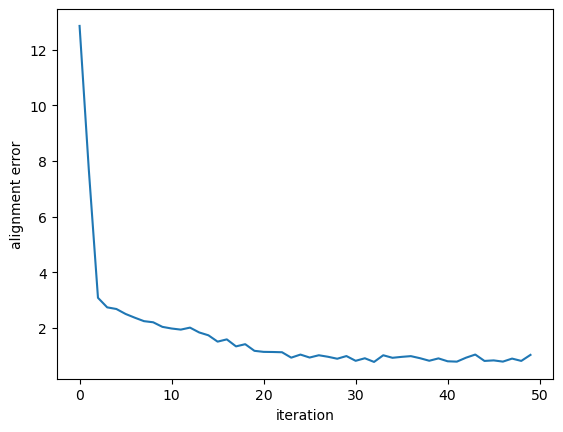

In [5]:
M2_transformed, error = transform_model(M1, M2, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.plot(error)
#plt.savefig("q1_error.png")
plt.show()

In [6]:
# export result
M2.export('bunny_q1.ply')
print("done")

done


/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


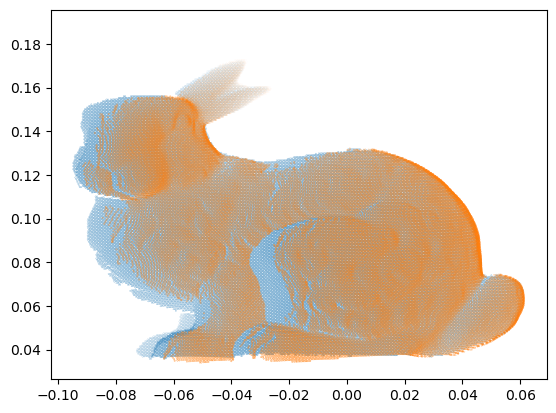

In [7]:
plt.scatter(M1.vertices[:,0], M1.vertices[:,1], M1.vertices[:,2])
plt.scatter(M2_transformed.vertices[:,0], M2_transformed.vertices[:,1], M2_transformed.vertices[:,2])
plt.show()

**2. Simulate the effect of increasing misalignment of $\mathbf{R}$ with rotation angle $\theta$.**

Pick a range of angles from $0$ to $360^{\circ}$, draw the final alignment error for each angle

In [8]:
theta = np.arange(0, 360, 45)

N = len(theta)
errors = np.zeros(N)

for i in range(N):
    
    # rotate mesh
    angle = np.radians(theta[i])
    direction = [0, 0, 1]
    center = [0, 0, 0]
    rot_matrix = trimesh.transformations.rotation_matrix(angle, direction, center)

    target = M1.copy()
    source = M1.copy()
    source.apply_transform(rot_matrix)
    
    # perform alignment and record error
    source_transformed, error = transform_model(target, source, iterations=100)
    errors[i] = error[-1]


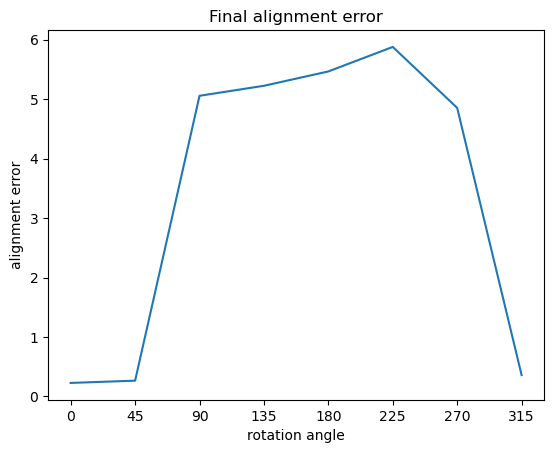

In [9]:
str_theta = [str(i) for i in theta]

plt.xlabel("rotation angle")
plt.ylabel("alignment error")
plt.title("Final alignment error")
plt.plot(str_theta, errors)
#plt.savefig("q2_overall_error.png")
plt.show()

**3. Perturb model M2 to simulate a noisy model.**

Pick a range of std from $0.0001$ to $0.1$, draw the final alignment error for std

In [10]:
std = [0.0001, 0.001, 0.005, 0.01, 0.02]

n = len(std)
errors = np.zeros(n)

for i in range(n):
    
    # add noise
    M2_noisy = M2.copy()
    N, dim = M2_noisy.vertices.shape
    noise = np.random.normal(0, std[i], (N, dim))
    M2_noisy.vertices += noise
    
    # perform alignment and record error
    M2_noisy, error = transform_model(M1, M2_noisy, iterations=50)
    errors[i] = error[-1]
    

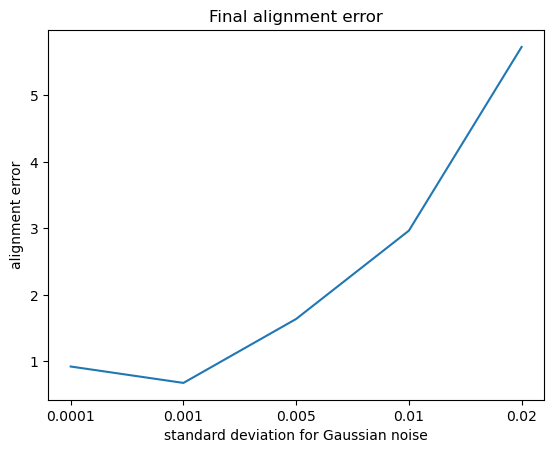

In [11]:
str_std = [str(i) for i in std]

plt.xlabel("standard deviation for Gaussian noise")
plt.ylabel("alignment error")
plt.title("Final alignment error")
plt.plot(str_std, errors)
#plt.savefig("q3_overall_error.png")
plt.show()

Case of $\sigma=0.0001$

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


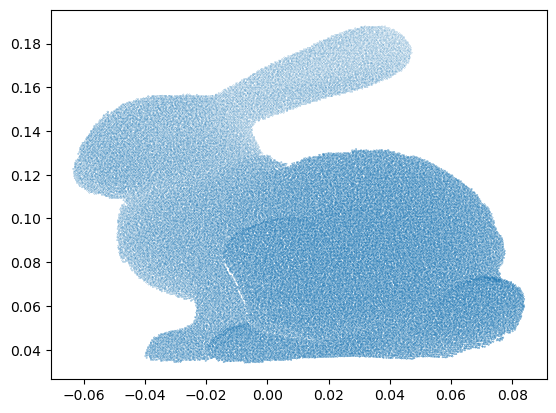

In [21]:
M2_noisy = M2.copy()
N, dim = M2_noisy.vertices.shape

# add noise with std = 10^-4 to model M2
std = 0.0001
noise = np.random.normal(0, std, (N, dim))
M2_noisy.vertices += noise

plt.scatter(M2_noisy.vertices[:,0], M2_noisy.vertices[:,1], M2_noisy.vertices[:,2])
#plt.savefig("q3-0.0001-before.png")
plt.show()

In [22]:
# export noisy model
#M2_noisy.export('bunny_q3_0.0001_before.ply')
#print("done")

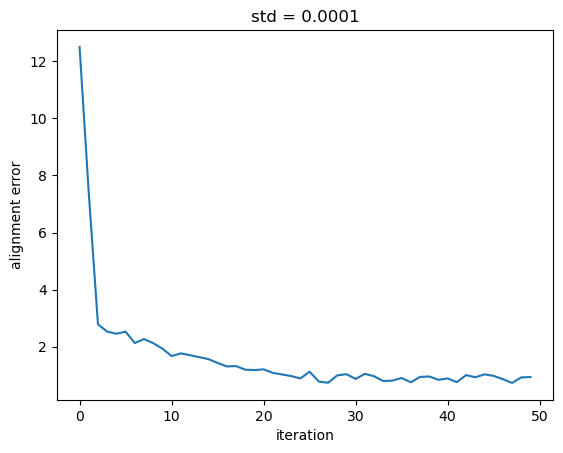

In [23]:
# perform transformations
M2_noisy, error = transform_model(M1, M2_noisy, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("std = 0.0001")
plt.plot(error)
#plt.savefig("q3_error_0.0001.png")
plt.show()

# export result
#M2_noisy.export('bunny_q3_0.0001_after.ply')
#print("done")

Case of $\sigma=0.001$

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


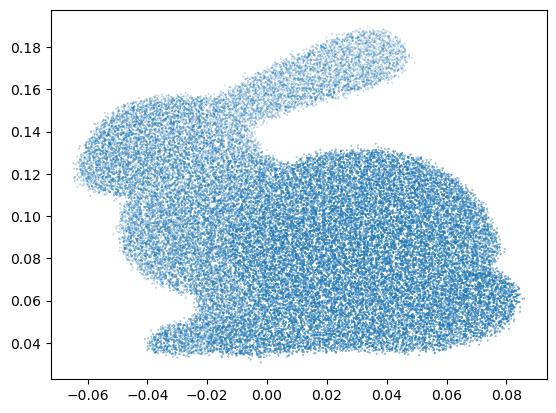

In [24]:
M2_noisy = M2.copy()
N, dim = M2_noisy.vertices.shape

# add noise with std = 10^-3 to model M2
std = 0.001
noise = np.random.normal(0, std, (N, dim))
M2_noisy.vertices += noise

plt.scatter(M2_noisy.vertices[:,0], M2_noisy.vertices[:,1], M2_noisy.vertices[:,2])
#plt.savefig("q3-0.001-before.png")
plt.show()

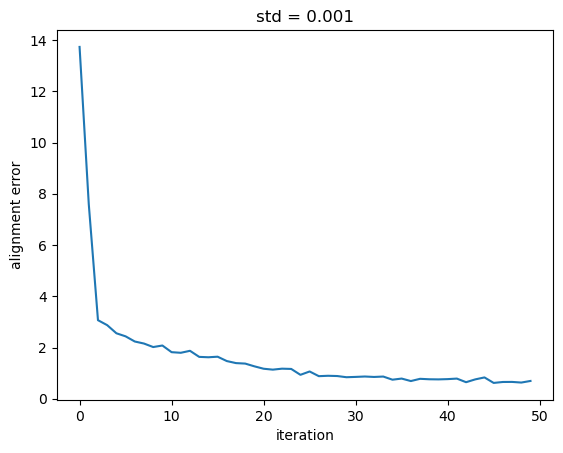

In [25]:
# export noisy model
#M2_noisy.export('bunny_q3_0.001_before.ply')
#print("done")

# perform transformations
M2_noisy, error = transform_model(M1, M2_noisy, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("std = 0.001")
plt.plot(error)
#plt.savefig("q3_error_0.001.png")
plt.show()

# export result
#M2_noisy.export('bunny_q3_0.001_after.ply')
#print("done")

Case of $\sigma=0.01$

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


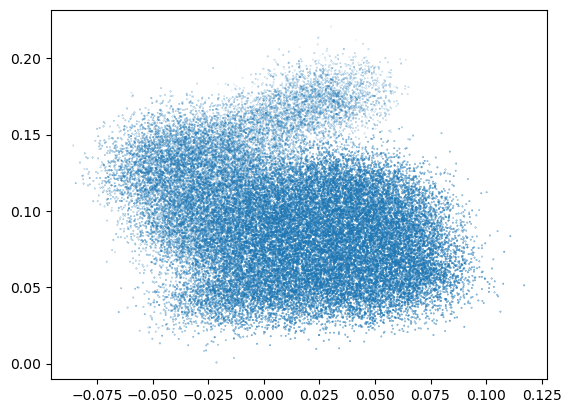

In [26]:
M2_noisy = M2.copy()
N, dim = M2_noisy.vertices.shape

# add noise with std = 10^-2 to model M2
std = 0.01
noise = np.random.normal(0, std, (N, dim))
M2_noisy.vertices += noise

plt.scatter(M2_noisy.vertices[:,0], M2_noisy.vertices[:,1], M2_noisy.vertices[:,2])
#plt.savefig("q3-0.01-before.png")
plt.show()

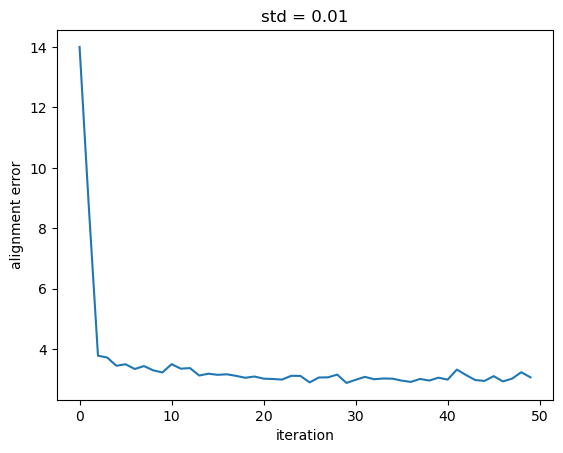

In [27]:
# export noisy model
#M2_noisy.export('bunny_q3_0.01_before.ply')
#print("done")

# perform transformations
M2_noisy, error = transform_model(M1, M2_noisy, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("std = 0.01")
plt.plot(error)
#plt.savefig("q3_error_0.01.png")
plt.show()

# export result
#M2_noisy.export('bunny_q3_0.01_after.ply')
#print("done")

**4. Test accuracy with increasing subsampling rates.**

In [28]:
# tranform M2 and return alignment error for each iteration

def transform_model_subsampling(M1, M2, sampling_rate, iterations=50):
    
    """    
    Arguments:
    M1: target model
    M2: source model to be transformed
    
    Return:
    M2_transformed: source model after transformation
    error: a list of alignment error for each iteration
    """
    st = time.time()
    
    M2_transformed = M2.copy()
    error = np.zeros(iterations)
    
    ps_1 = M1.vertices
    tree = KDTree(ps_1)
    
    sample_nb = int(sampling_rate * M2.vertices.shape[0])

    for it in range(iterations):

        # 1. Sampling points on the surface of the mesh M2
        ps_2 = M2_transformed.sample(sample_nb)

        # 2. Match each point from ps_1 to closet point from ps_2
        distances, indices = tree.query(ps_2, 1)
        distances, indices = distances.ravel(), indices.ravel()
        error[it] = np.mean(distances) # compute alignment error

        # 3. Reject 10% bad pair
        sorted_d = distances.copy()
        sorted_d.sort()
        index = sorted_d.shape[0] // 10
        threshold = sorted_d[-index]

        pointset_1 = []
        pointset_2 = []
        for i, d in enumerate(distances):
            if d < threshold:
                pointset_1.append(np.array(ps_1[indices[i]]))
                pointset_2.append(np.array(ps_2[i]))

        pointset_1 = np.array(pointset_1)
        pointset_2 = np.array(pointset_2)

        # 4. Compute rotation R and translation t to minimize
        R, t = fit_transform(pointset_1, pointset_2)

        # 5. Apply transformation
        dim = R.shape[1]
        T = np.identity(dim+1)
        T[:dim, :dim] = R
        T[:dim, dim] = t
        M2_transformed.apply_transform(T)
    
    et = time.time()
    execution_time = et - st
    
    return M2_transformed, error, execution_time

Pick a range of sampling rate from $0.001$ to $1$, draw the final alignment error for each sampling rate.

In [29]:
sampling_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 1]

n = len(sampling_rate)
errors = np.zeros(n)
execution_times = np.zeros(n)

for i in range(n):
    target = M1.copy()
    source = M2.copy()
    M2_transformed, error, t = transform_model_subsampling(target, source, \
                               sampling_rate[i], iterations=50)
    errors[i] = error[-1]
    execution_times[i] = t

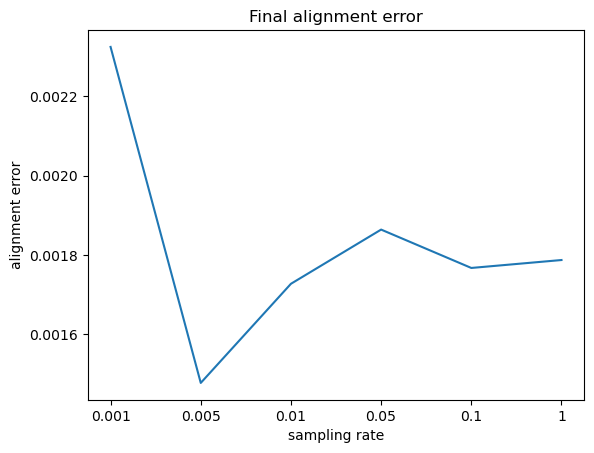

In [30]:
str_sampling_rate = [str(i) for i in sampling_rate]

plt.xlabel("sampling rate")
plt.ylabel("alignment error")
plt.title("Final alignment error")
plt.plot(str_sampling_rate, errors)
#plt.savefig("q4_overall_error.png")
plt.show()

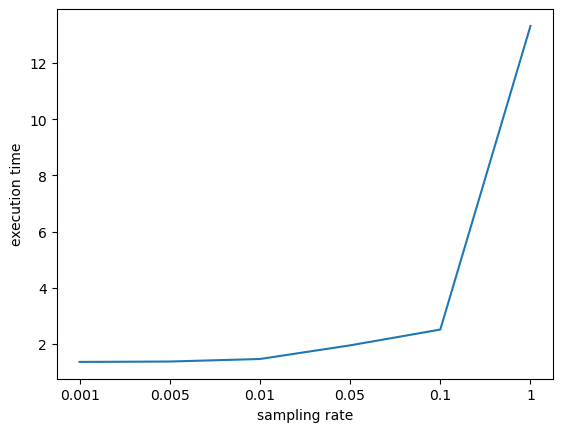

In [31]:
str_sampling_rate = [str(i) for i in sampling_rate]

plt.xlabel("sampling rate")
plt.ylabel("execution time")
plt.plot(str_sampling_rate, execution_times)
#plt.savefig("q4_execution_time.png")
plt.show()

Case of sampling rate $= 0.001$. $(N\sim 40)$

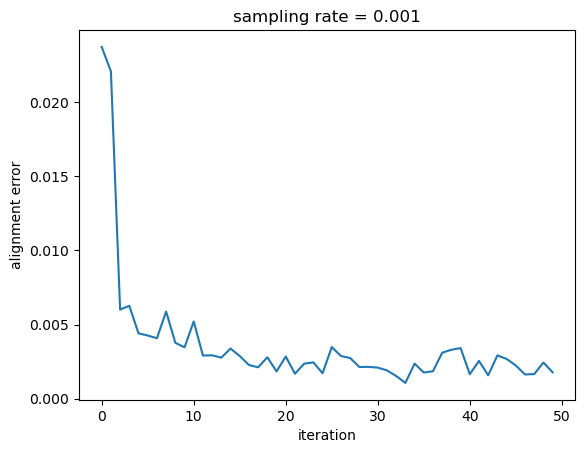

In [32]:
sampling_rate = 0.001

target = M1.copy()
source = M2.copy()
M2_transformed, error,_ = transform_model_subsampling(target, source, \
                        sampling_rate, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("sampling rate = 0.001")
plt.plot(error)
#plt.savefig("q4_error_0.001.png")
plt.show()

Case of sampling rate $= 0.01$. $(N\sim 400)$

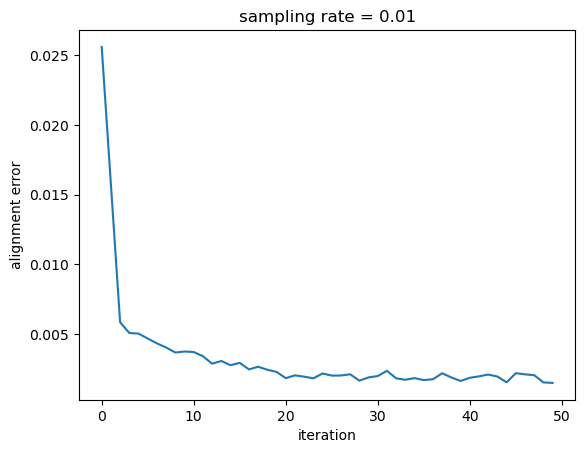

In [33]:
sampling_rate = 0.01

target = M1.copy()
source = M2.copy()
M2_transformed, error,_ = transform_model_subsampling(target, source,\
                        sampling_rate, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("sampling rate = 0.01")
plt.plot(error)
#plt.savefig("q4_error_0.01.png")
plt.show()

Case of sampling rate $= 0.1$. $(N\sim 4000)$

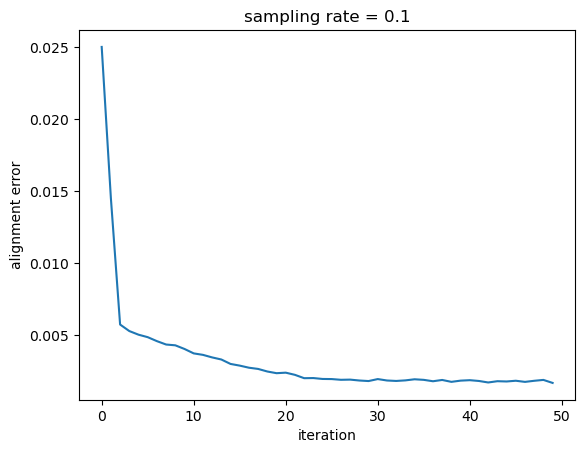

In [34]:
sampling_rate = 0.1

target = M1.copy()
source = M2.copy()
M2_transformed, error,_ = transform_model_subsampling(target, source, \
                        sampling_rate, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("sampling rate = 0.1")
plt.plot(error)
#plt.savefig("q4_error_0.1.png")
plt.show()

Case of sampling rate $= 1$. $(N\sim 40000)$

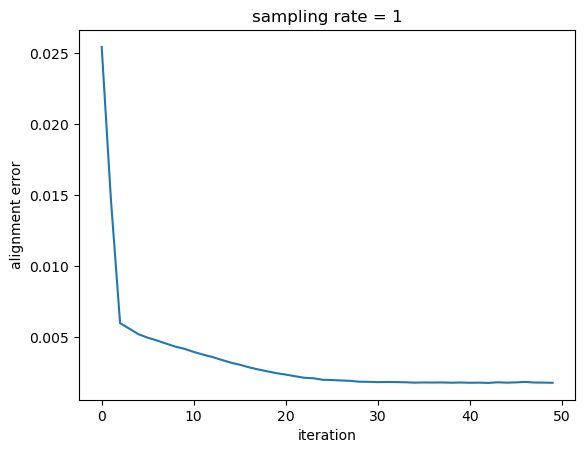

In [35]:
sampling_rate = 1

target = M1.copy()
source = M2.copy()
M2_transformed, error, _ = transform_model_subsampling(target, source, \
                        sampling_rate, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("sampling rate = 1")
plt.plot(error)
#plt.savefig("q4_error_1.png")
plt.show()

**5. Now given multiple scans M1,M2,...M5 align all of them to a common global coordinate frame.**

We first try to align bunny 00, 45, 90, 270 and 315.

In [36]:
# load models

# Load origin mesh M1
path_M1 = os.path.join(MODEL_PATH,'bun000_v2.ply')
assert os.path.exists(path_M1), 'Cannot find:' + path_M1
M_00 = trimesh.load(path_M1)

# Load mesh M2
path_M2 = os.path.join(MODEL_PATH,'bun045_v2.ply')
assert os.path.exists(path_M2), 'Cannot find:' + path_M2
M_45 = trimesh.load(path_M2)

# Load mesh M3
path_M3 = os.path.join(MODEL_PATH,'bun090_v2.ply')
assert os.path.exists(path_M3), 'Cannot find:' + path_M3
M_90 = trimesh.load(path_M3)

# Load mesh M4
path_M4 = os.path.join(MODEL_PATH,'bun270_v2.ply')
assert os.path.exists(path_M4), 'Cannot find:' + path_M4
M_270 = trimesh.load(path_M4)

# Load mesh M5
path_M5 = os.path.join(MODEL_PATH,'bun315_v2.ply')
assert os.path.exists(path_M5), 'Cannot find:' + path_M5
M_315 = trimesh.load(path_M5)

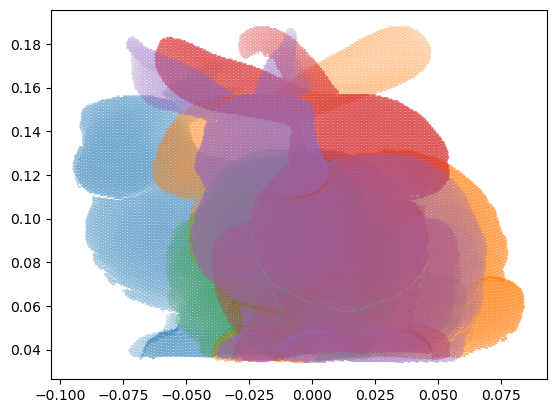

In [38]:
# print models before transformations

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_45.vertices[:,0], M_45.vertices[:,1], M_45.vertices[:,2])
plt.scatter(M_90.vertices[:,0], M_90.vertices[:,1], M_90.vertices[:,2])
plt.scatter(M_270.vertices[:,0], M_270.vertices[:,1], M_270.vertices[:,2])
plt.scatter(M_315.vertices[:,0], M_315.vertices[:,1], M_315.vertices[:,2])
plt.savefig("original.png")
plt.show()

#M_00.export('step1_00.ply')
#M_45.export('step1_45.ply')
#M_90.export('step1_90.ply')
#M_270.export('step1_270.ply')
#M_315.export('step1_315.ply')
#print("done")

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


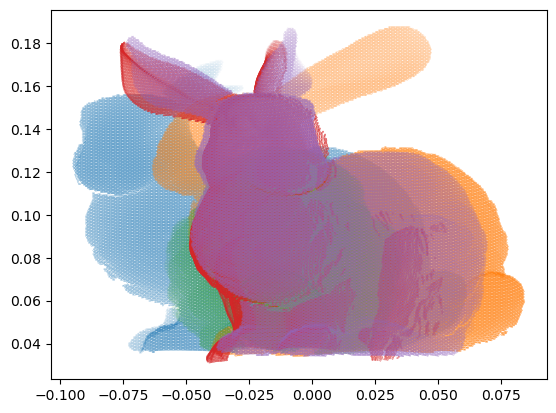

In [39]:
# align bunny_270 to bunny_315(pink)

M_270, error = transform_model(M_315, M_270, iterations=100)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_45.vertices[:,0], M_45.vertices[:,1], M_45.vertices[:,2])
plt.scatter(M_90.vertices[:,0], M_90.vertices[:,1], M_90.vertices[:,2])
plt.scatter(M_270.vertices[:,0], M_270.vertices[:,1], M_270.vertices[:,2])
plt.scatter(M_315.vertices[:,0], M_315.vertices[:,1], M_315.vertices[:,2])
#plt.savefig("step1.png")
plt.show()

#M_270.export('step1_270.ply')
#print("done")

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


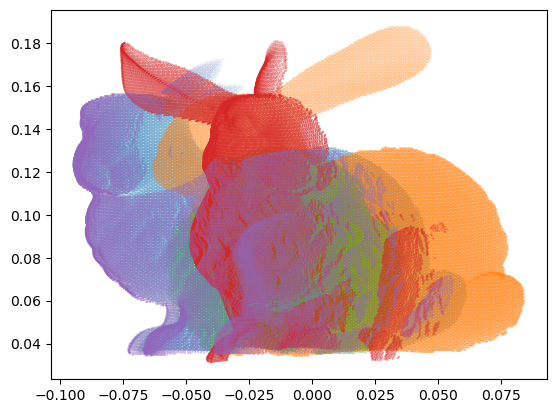

In [40]:
# align bunny_315 to bunny_00(purple)

M_315, error = transform_model(M_00, M_315, iterations=100)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_45.vertices[:,0], M_45.vertices[:,1], M_45.vertices[:,2])
plt.scatter(M_90.vertices[:,0], M_90.vertices[:,1], M_90.vertices[:,2])
plt.scatter(M_270.vertices[:,0], M_270.vertices[:,1], M_270.vertices[:,2])
plt.scatter(M_315.vertices[:,0], M_315.vertices[:,1], M_315.vertices[:,2])
#plt.savefig("step2.png")
plt.show()

#M_315.export('step2_315.ply')
#print("done")

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


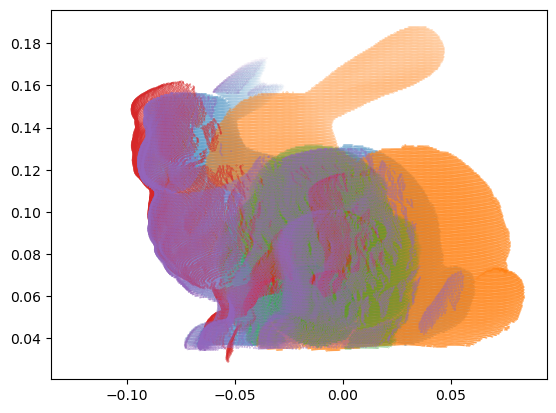

In [41]:
# align bunny_270 to bunny_315(pink)

M_270, error = transform_model(M_315, M_270, iterations=100)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_45.vertices[:,0], M_45.vertices[:,1], M_45.vertices[:,2])
plt.scatter(M_90.vertices[:,0], M_90.vertices[:,1], M_90.vertices[:,2])
plt.scatter(M_270.vertices[:,0], M_270.vertices[:,1], M_270.vertices[:,2])
plt.scatter(M_315.vertices[:,0], M_315.vertices[:,1], M_315.vertices[:,2])
#plt.savefig("step3.png")
plt.show()

#M_270.export('step3_270.ply')
#print("done")

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


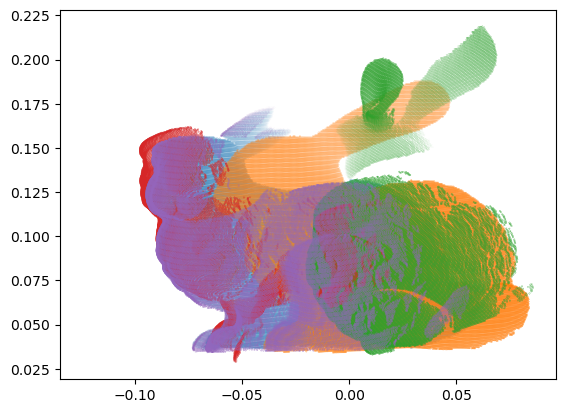

In [42]:
# align bunny_90 to bunny_45(green)

M_90, error = transform_model(M_45, M_90, iterations=100)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_45.vertices[:,0], M_45.vertices[:,1], M_45.vertices[:,2])
plt.scatter(M_90.vertices[:,0], M_90.vertices[:,1], M_90.vertices[:,2])
plt.scatter(M_270.vertices[:,0], M_270.vertices[:,1], M_270.vertices[:,2])
plt.scatter(M_315.vertices[:,0], M_315.vertices[:,1], M_315.vertices[:,2])
#plt.savefig("step4.png")
plt.show()

#M_90.export('step4_90.ply')
#print("done")

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


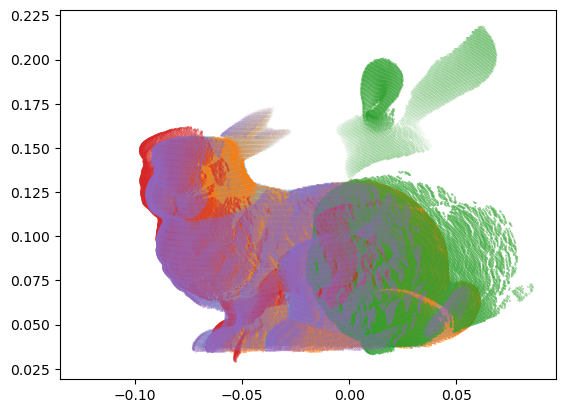

In [43]:
# align bunny_45 to bunny_00(orange)

M_45, error = transform_model(M_00, M_45, iterations=100)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_45.vertices[:,0], M_45.vertices[:,1], M_45.vertices[:,2])
plt.scatter(M_90.vertices[:,0], M_90.vertices[:,1], M_90.vertices[:,2])
plt.scatter(M_270.vertices[:,0], M_270.vertices[:,1], M_270.vertices[:,2])
plt.scatter(M_315.vertices[:,0], M_315.vertices[:,1], M_315.vertices[:,2])
#plt.savefig("step5.png")
plt.show()

#M_45.export('step5_45.ply')
#print("done")

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


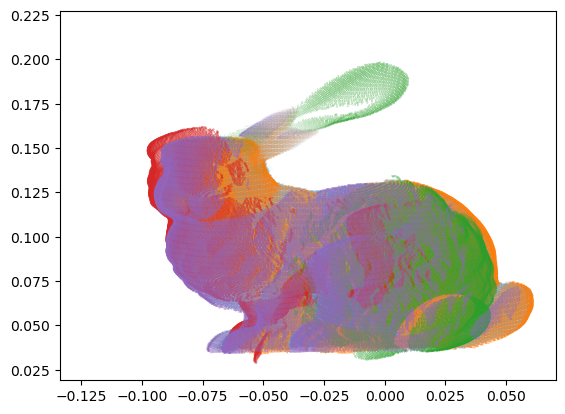

In [44]:
# align bunny_90 to bunny_45

M_90, error = transform_model(M_45, M_90, iterations=100)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_45.vertices[:,0], M_45.vertices[:,1], M_45.vertices[:,2])
plt.scatter(M_90.vertices[:,0], M_90.vertices[:,1], M_90.vertices[:,2])
plt.scatter(M_270.vertices[:,0], M_270.vertices[:,1], M_270.vertices[:,2])
plt.scatter(M_315.vertices[:,0], M_315.vertices[:,1], M_315.vertices[:,2])
#plt.savefig("step6.png")
plt.show()

#M_90.export('step6_90.ply')
#print("done")

Here is a demonstration of how to align bunny 180 to any bunny models in the file.

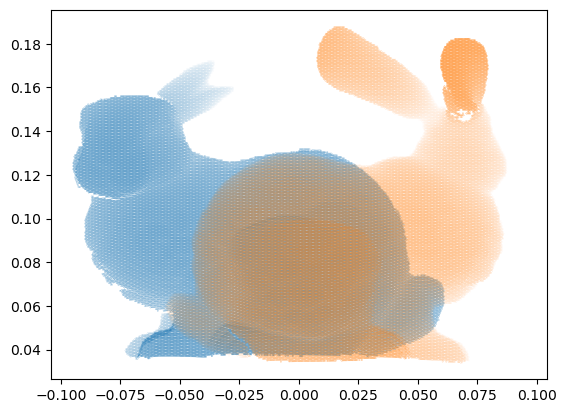

In [45]:
# Load bunny 180 mesh
path_M6 = os.path.join(MODEL_PATH,'bun180_v2.ply')
assert os.path.exists(path_M6), 'Cannot find:' + path_M6
M_180 = trimesh.load(path_M6)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_180.vertices[:,0], M_180.vertices[:,1], M_180.vertices[:,2])
plt.show()

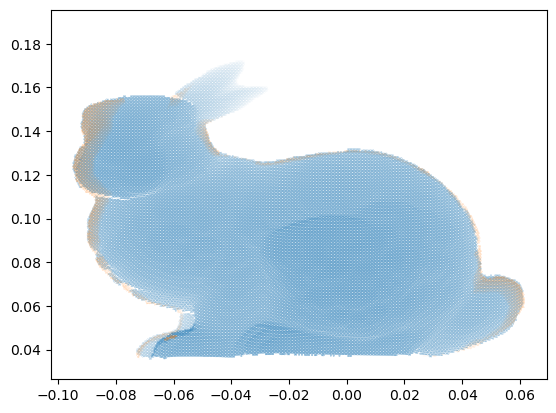

In [46]:
# Rotate 180 degrees along the z-axis

angle = np.radians(180)
direction = [0, 1, 0]
center = [0, 0, 0]
rot_matrix = trimesh.transformations.rotation_matrix(angle, direction, center)

M_180.apply_transform(rot_matrix)

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_180.vertices[:,0], M_180.vertices[:,1], M_180.vertices[:,2])
plt.show()

In [ ]:
M_180.export('bunny_q5_180_after_rotation.ply')
print()

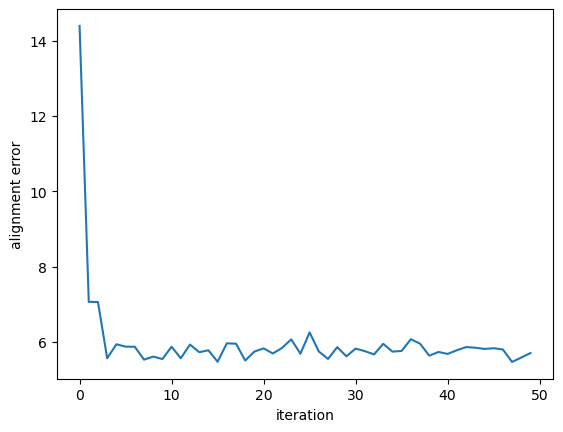

/Users/lixiyao/opt/anaconda3/envs/geo_tutorials/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


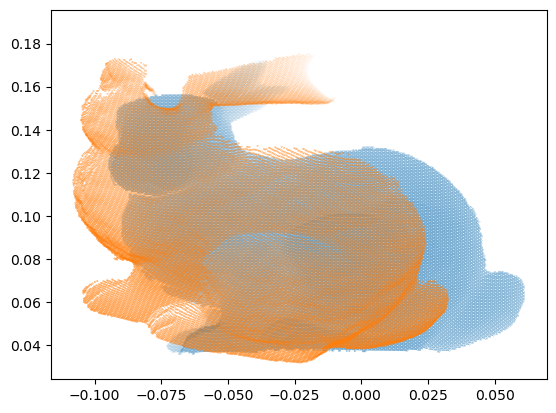

In [47]:
# Perform alignment

M_180, error = transform_model(M_00, M_180, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.plot(error)
#plt.savefig("q5_error_180.png")
plt.show()

plt.scatter(M_00.vertices[:,0], M_00.vertices[:,1], M_00.vertices[:,2])
plt.scatter(M_180.vertices[:,0], M_180.vertices[:,1], M_180.vertices[:,2])
plt.show()

#M_180.export('bunny_q5_180_after_alignment.ply')
print()

**6. Now assume that you have access to normals at each vertex of the meshes. Update your viewer to shade the models based on these normals. Now, use the normal information to improve the ICP performance.**

Compute the normal for each vertice of mesh M2 using least square plane fitting

In [48]:
# Compute rotation R and translation t to minimize

def fit_transform_point_to_plane(ps1, ps2, normals):
    """    
    Arguments:
    ps1: (N*d) numpy array of pointset from destination model
    ps2: (N*d) numpy array of pointset from source model
    normals: (N*d) numpy array of normal of sampled vertices from source model
    
    Return:
    T: ((d+1)*(d+1)) transform matrix
    R: (d*d) rotation matrix
    t: (d*1) translation vector
    """
    N = ps1.shape[0]
    A = np.zeros((N,6))
    b = np.zeros(N)
    
    A[:,0] = normals[:,2] * ps2[:,1] - normals[:,1] * ps2[:,2]
    A[:,1] = normals[:,0] * ps2[:,2] - normals[:,2] * ps2[:,0]
    A[:,2] = normals[:,1] * ps2[:,0] - normals[:,0] * ps2[:,1]
    A[:,3:] = normals
    
    b = np.sum(normals * ps1, axis=1) - np.sum(normals * ps2, axis=1)
    
    x = np.dot(np.linalg.pinv(A), b)
    alpha, beta, gamma = x[0], x[1], x[2]
    T = transformations.euler_matrix(x[0], x[1], x[2])
    T[0, 3] = x[3]
    T[1, 3] = x[4]
    T[2, 3] = x[5]

    R = T[:3, :3]
    t = T[:3, 3]

    return T, R, t

In [49]:
# tranform M2 using the point to plane distance as an optimisation

def transform_model_normal(M1, M2, iterations=50):
    
    """    
    Arguments:
    M1: target model
    M2: source model to be transformed
    
    Return:
    M2_transformed: source model after transformation
    error: a list of alignment error for each iteration
    """
    
    M2_transformed = M2.copy()
    error = np.zeros(iterations)
   
    ps_1_total = M1.vertices
    tree = KDTree(ps_1_total)
    
    # get normal for target model
    normals_1_total = M1.vertex_normals
    
    for it in range(iterations):

        # 1. Sampling points on the surface of the mesh M2
        ps_2 = M2_transformed.sample(500)

        # 2. Match each point from ps_2 to closet point from ps_1
        _, indices = tree.query(ps_2, 1)
        indices = indices.ravel()
        ps_1 = ps_1_total[indices]
        normals_1 = normals_1_total[indices]
        
        # compute point-to-plane distance
        dist_point_plane = np.abs(np.sum(normals_1 * (ps_2 - ps_1), axis=1))
        error[it] = np.sum(dist_point_plane)

        # 3. Reject 10% bad pair
        sorted_d = dist_point_plane.copy()
        sorted_d.sort()
        index = sorted_d.shape[0] // 10
        threshold = sorted_d[-index]
                
        pointset_1 = []
        pointset_2 = []
        normals = []
        
        for i, d in enumerate(dist_point_plane):
            if d < threshold:
                pointset_1.append(np.array(ps_1[i]))
                pointset_2.append(np.array(ps_2[i]))
                normals.append(normals_1[i])
                
        pointset_1 = np.array(pointset_1)
        pointset_2 = np.array(pointset_2)
        normals = np.array(normals)
        
        # 4. Compute rotation R and translation t to minimize
        T, R, t = fit_transform_point_to_plane(pointset_1, pointset_2, normals)
        
        # 5. Apply transformation
        M2_transformed.apply_transform(T)
        
    return M2_transformed, error

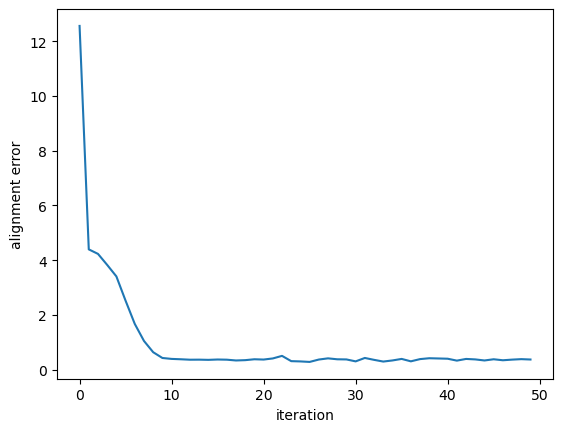

In [50]:
M2_transformed, error = transform_model_normal(M1, M2, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.plot(error)
#plt.savefig("q6_error.png")
plt.show()

An example of point-to-plane ICP works better on noisy model

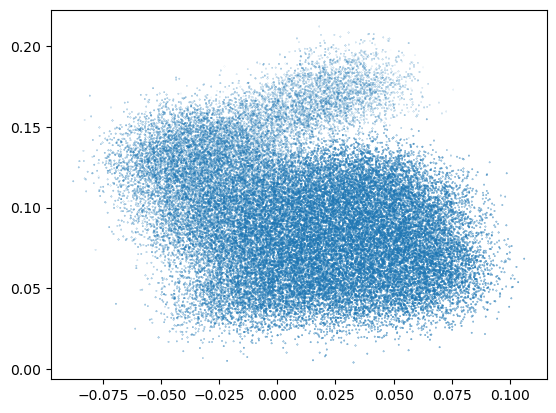

In [52]:
M2_noisy = M2.copy()
N, dim = M2_noisy.vertices.shape

# add noise with std = 10^-2 to model M2
std = 0.01
noise = np.random.normal(0, std, (N, dim))
M2_noisy.vertices += noise

plt.scatter(M2_noisy.vertices[:,0], M2_noisy.vertices[:,1], M2_noisy.vertices[:,2])
plt.show()

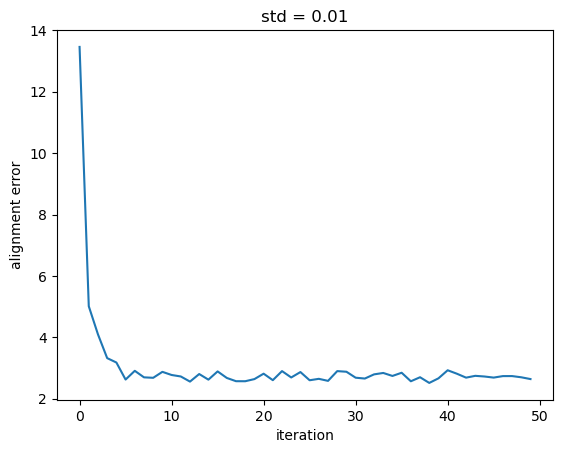

In [53]:
# perform transformations
M2_noisy, error = transform_model_normal(M1, M2_noisy, iterations=50)

plt.xlabel("iteration")
plt.ylabel("alignment error")
plt.title("std = 0.01")
plt.plot(error)
#plt.savefig("q6_noisy_0.01.png")
plt.show()